### Probabilistic Generative Models -- Coursework 1
## Part 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize


In [2]:
# kernels

def SE(x, y, theta):
    ### TO BE IMPLEMENTED (Task 1)
    l, sigma, _ = theta
    x = x[:, None]
    y = y[None,: ]
    d = (x - y) ** 2
    K = sigma ** 2 * np.exp(- d / (2 * l ** 2))
    return K


def SE_wnoise(x, theta):
    x = np.atleast_1d(x)
    K = SE(x, x, theta)
    _, _, sigma2_e = theta
    return K + sigma2_e * np.eye(len(x))

def Laplace(x, y, theta):
    ### TO BE IMPLEMENTED (Task 1)
    l, sigma, _ = theta
    x = x[:, None]
    y = y[None,: ]
    d = np.abs(x - y)
    K = sigma ** 2 * np.exp(- d / (2 * l ** 2))
    return K

def Laplace_wnoise(x, theta):
    x = np.atleast_1d(x)
    K = Laplace(x, x, theta)
    _, _, sigma2_e = theta
    return K + sigma2_e * np.eye(len(x))


In [52]:
class MyFirstGP:

    def __init__(self, kernel, mean=0):
        self.mean = mean # we'll work with mean = 0 here
        self.kernel = kernel # only an id, e.g., 'SE' or 'Lap'

    def init_hypers(self, theta):
    #set the hyperparameters based on the argument theta
        self.theta = theta
	
    def show_hypers(self):
    #shows the current hyperparameters (this might be needed for debugging)
        print(f'hypers are {self.theta}')

    def load_data(self, x, y):
    #load the input-output observations (dimension N_data)
        self.x_obs = x
        self.y_obs = y

    def set_space(self, x):
    #set the discrete grid on which the GP will be defined (dimension N_space)
        self.space = x
    
    def sample_from_prior(self, trajectories=5):

        if self.kernel == 'SE':
            K = SE(self.space, self.space, self.theta)
        elif self.kernel == 'Laplace':
            K = Laplace(self.space, self.space, self.theta)
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")
        
        self.K_prior = K

        n = len(self.space)

        # Cholesky (with jitter)
        L = np.linalg.cholesky(K + 1e-10 * np.eye(n))

        # trajectories from N(0, K):
        z = np.random.randn(n, trajectories)         
        self.prior_samples = (L @ z).T      
    
    def plot_prior(self, title='Plot from the GP prior'):
        x = self.space
        samples = self.prior_samples
        var = np.diag(self.K_prior)

        plt.figure(figsize=(15,5))
        for s in samples:
            plt.plot(x, s, color='gray', alpha=0.5)

        plt.plot(x, np.zeros_like(x), color='black', lw=1, label='prior mean')
        plt.fill_between(
            x,
            -2 * np.sqrt(var),
            2 * np.sqrt(var),
            color='blue',
            alpha=0.2, 
            label = 'credible interval'
        )

        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.legend()
        plt.title(title)
        plt.savefig(f"./prior_{self.kernel}_{np.max(self.space)}_{self.theta}.png")
        plt.show()
        

    def nlogp(self, hypers):
        ### TO BE IMPLEMENTED (Task 3)
        N = len(self.x_obs)
        y = self.y_obs

        if self.kernel == 'SE':
            K = SE_wnoise(self.x_obs, hypers)
        elif self.kernel == 'Laplace':
            K = Laplace_wnoise(self.x_obs, hypers)
        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")

        L = np.linalg.cholesky(K)

        v = np.linalg.solve(L, y)
        alpha = np.linalg.solve(L.T, v)

        nll = (
            0.5 * y @ alpha
            + np.sum(np.log(np.diag(L)))
            + 0.5 * N * np.log(2.0 * np.pi)
        )

        self.nlogp = nll

        return nll
    # method:"L-BFGS-B", "Nelder-Mead", "Powell",...
    def train(self, method):
        hypers0 = np.asarray(self.theta, dtype=float)

        # (signal var, lengthscale, noise var)
        # heuristic bounds for stable training
        bounds = [
            (1e-12, None),  # sigma2 > 0
            (1e-12, None),  # l > 0
            (1e-12, None),  # sigma2_e >= small positive (keeps K well-conditioned)
        ]

        res = minimize(
            self.nlogp,
            hypers0,
            method=method,
            bounds=bounds,
            options={'maxiter': 500, 'disp': False}
        )

        self.theta = res.x
        self.final_loss = res.fun


        return res, self.final_loss

    def sample_from_posterior(self, trajectories=5):
        x_obs = self.x_obs.reshape(-1)
        y = self.y_obs.reshape(-1)
        x_star = self.space.reshape(-1)

        N = x_obs.shape[0]
        M = x_star.shape[0]

        if self.kernel == 'SE':
            K = SE(x_obs, x_obs, self.theta)
            K_s = SE(x_obs, x_star, self.theta)
            K_ss = SE(x_star, x_star, self.theta)
            sigma2 = self.theta[-1]**2
            C = K + sigma2  * np.eye(N) + 1e-8 * np.eye(N)

        elif self.kernel == 'Laplace':
            K = Laplace(x_obs, x_obs, self.theta)
            K_s = Laplace(x_obs, x_star, self.theta)
            K_ss = Laplace(x_star, x_star, self.theta)
            sigma2 = self.theta[-1]**2
            C = K + sigma2  * np.eye(N) + 1e-8 * np.eye(N)

        else:
            raise ValueError(f"Unknown kernel: {self.kernel}")

        #print(K.shape)
        #print(K_s.shape)
        #print(K_ss.shape)

        L = np.linalg.cholesky(C)


        v = np.linalg.solve(L, y)
        alpha = np.linalg.solve(L.T, v)

        m_star = K_s.T @ alpha

        W = np.linalg.solve(L, K_s)
        Sigma_star = K_ss - W.T @ W


        L_star = np.linalg.cholesky(Sigma_star + 1e-6 * np.eye(M))
        z = np.random.randn(M, trajectories)
        samples = (m_star[:, None] + L_star @ z)


        self.post_mean = m_star
        self.post_cov = Sigma_star
        self.post_samples = samples.T




    def plot_posterior(self, title='Plot from the GP posterior'):
        ### TO BE IMPLEMENTED (Task 5)
        x = self.space
        samples = self.post_samples
        var = np.diag(self.post_cov)

        plt.figure(figsize=(15,5))
        for s in samples:
            plt.plot(x, s, color='gray', alpha=0.5)

        plt.plot(self.x_obs, self.y_obs, "o", color = 'blue', label = 'obs')
        plt.plot(x, self.post_mean, color='black', lw=1, label='post mean')
        plt.fill_between(
            x,
            self.post_mean-2 * np.sqrt(var),
            self.post_mean+2 * np.sqrt(var),
            color='blue',
            alpha=0.2,
            label = 'credible interval'
        )

        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.legend()
        plt.title(title)
        plt.savefig(f"./posterior_{self.kernel}")
        plt.show()



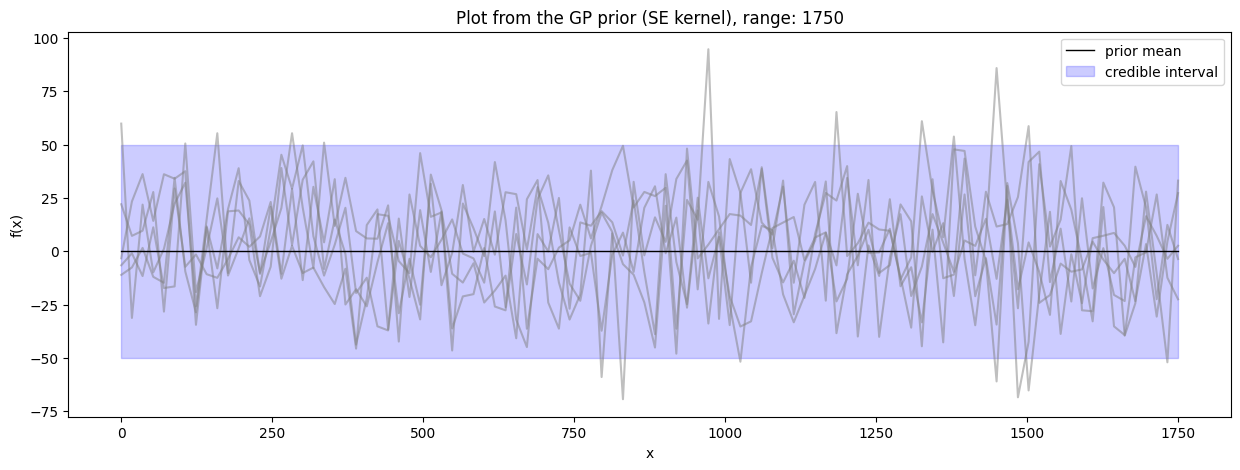

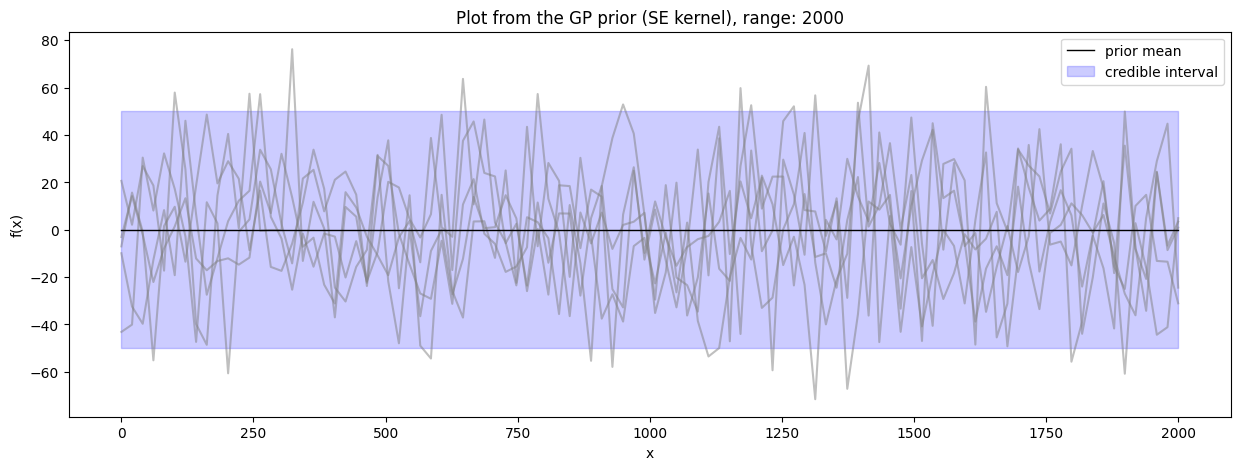

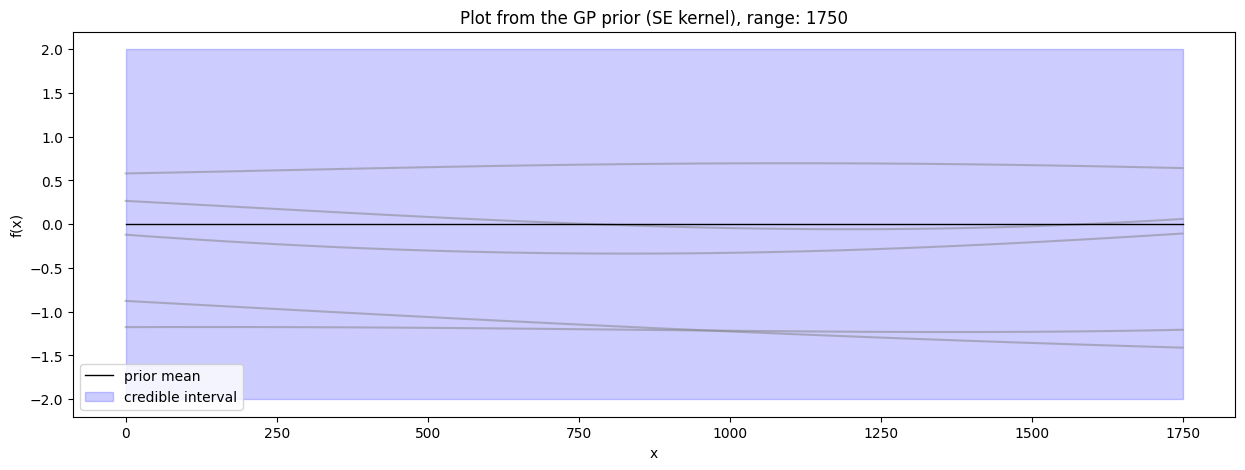

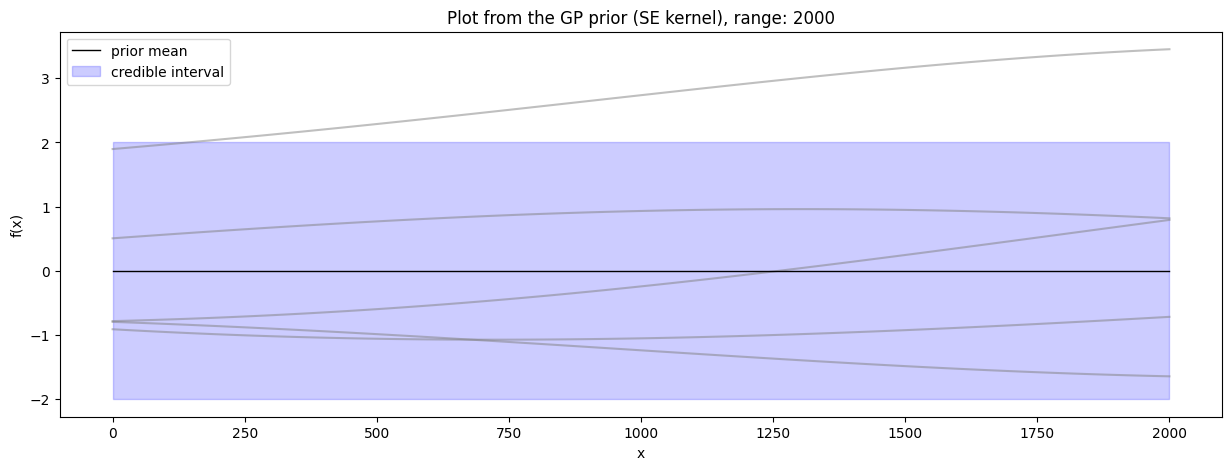

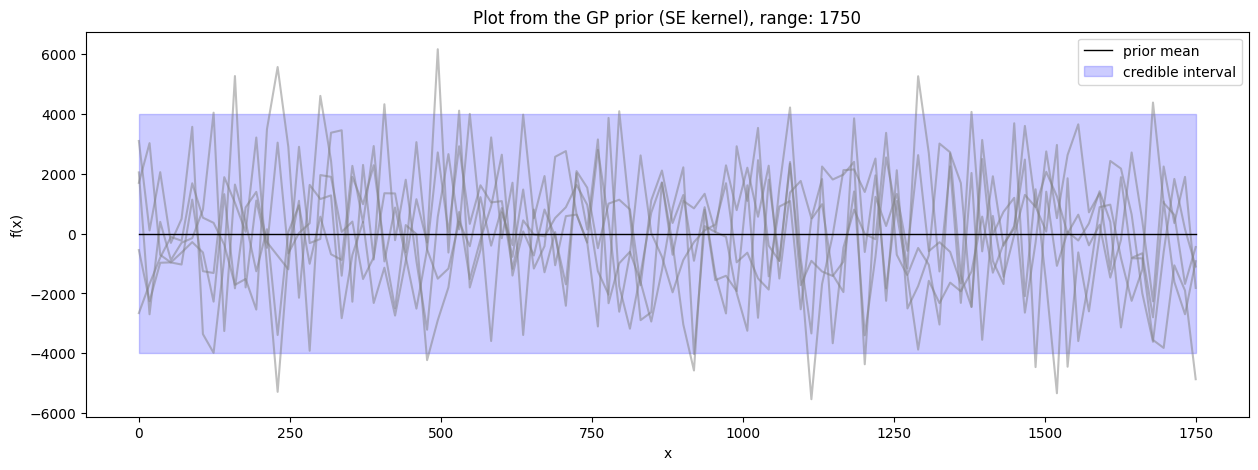

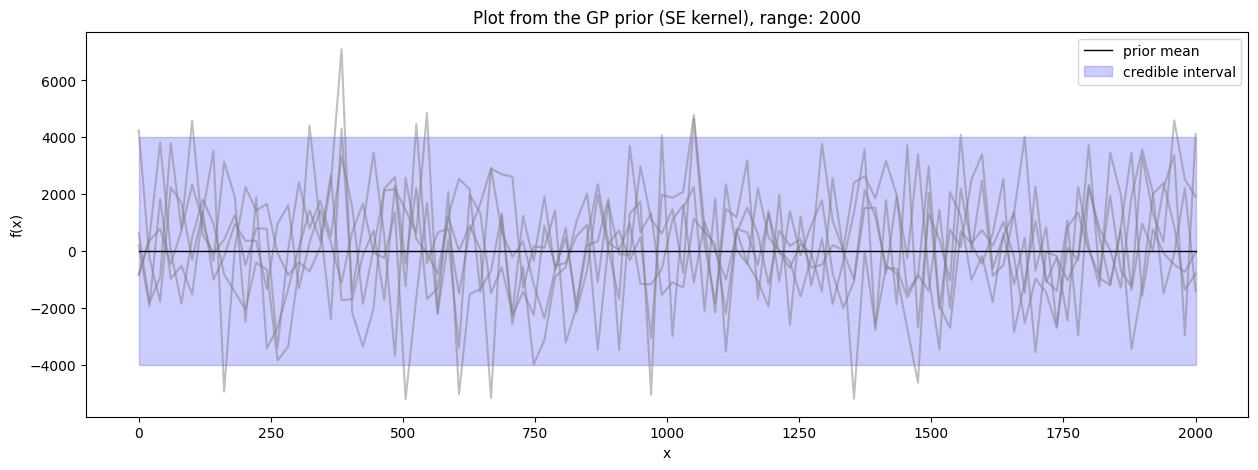

In [60]:
## Sample from the prior

# SE kernel
gp = MyFirstGP(kernel = 'SE')
gp.init_hypers(theta = [5,25,1])
gp.set_space(np.linspace(0, 1750, 100))

# sample and plot
gp.sample_from_prior(trajectories = 5)
gp.plot_prior(title = 'Plot from the GP prior (SE kernel), range: 1750')

gp.set_space(np.linspace(0, 2000, 100))
gp.sample_from_prior(trajectories=5)
gp.plot_prior(title = 'Plot from the GP prior (SE kernel), range: 2000')

gp.init_hypers(theta = [2000,1,1])
gp.set_space(np.linspace(0, 1750, 100))

gp.sample_from_prior(trajectories = 5)
gp.plot_prior(title = 'Plot from the GP prior (SE kernel), range: 1750')

gp.set_space(np.linspace(0, 2000, 100))
gp.sample_from_prior(trajectories=5)
gp.plot_prior(title = 'Plot from the GP prior (SE kernel), range: 2000')

gp.init_hypers(theta = [1,2000,1])
gp.set_space(np.linspace(0, 1750, 100))

gp.sample_from_prior(trajectories = 5)
gp.plot_prior(title = 'Plot from the GP prior (SE kernel), range: 1750')

gp.set_space(np.linspace(0, 2000, 100))
gp.sample_from_prior(trajectories=5)
gp.plot_prior(title = 'Plot from the GP prior (SE kernel), range: 2000')



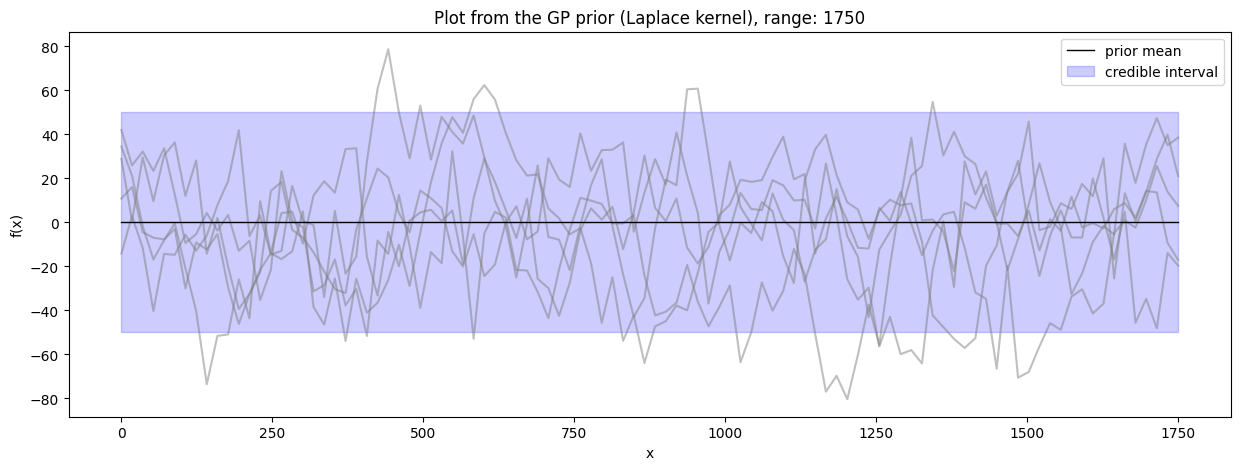

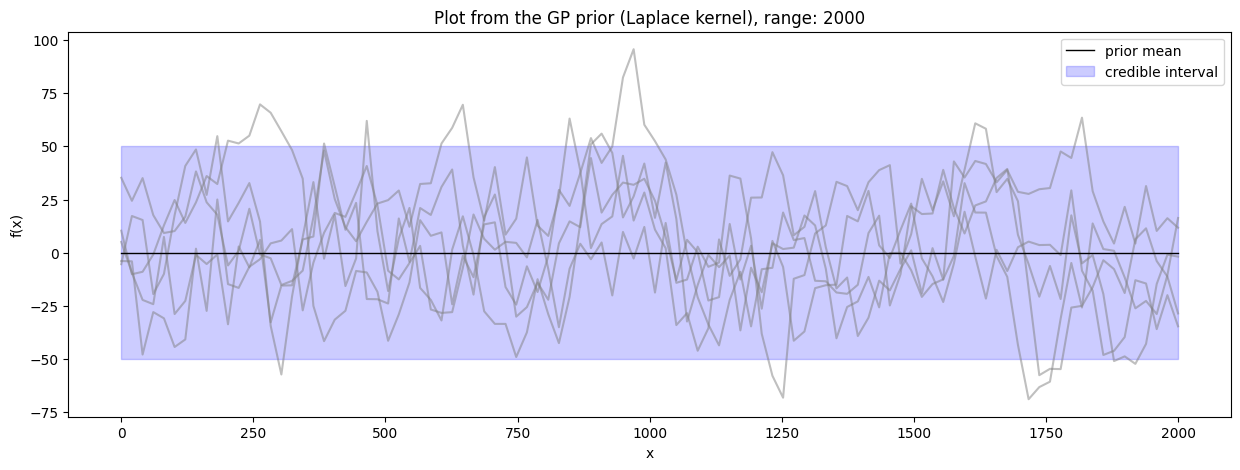

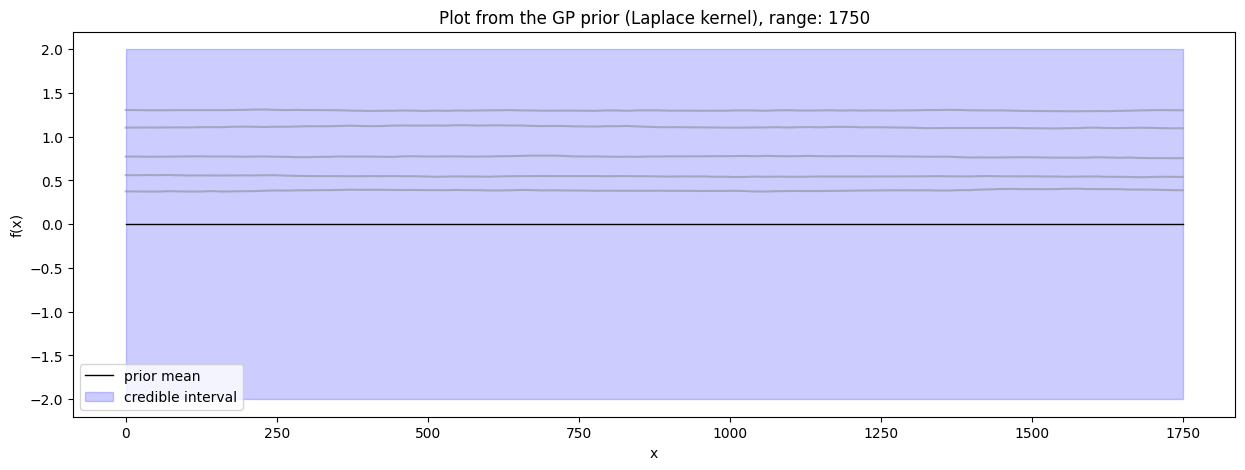

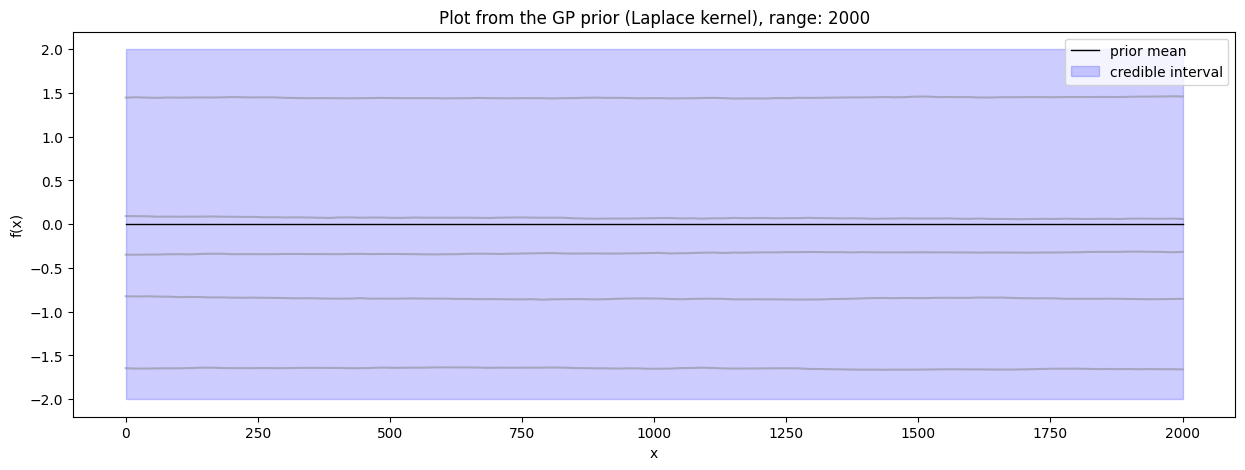

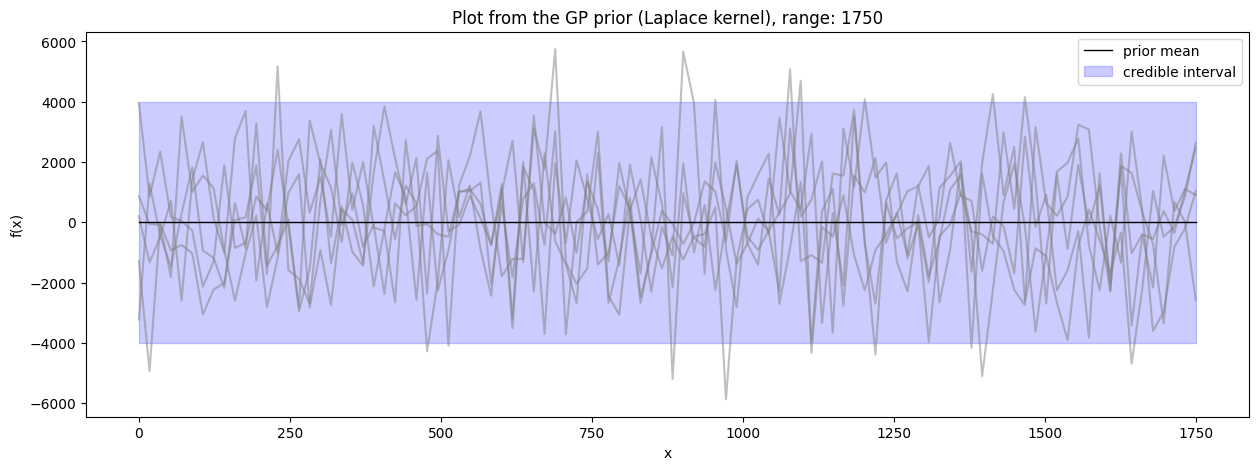

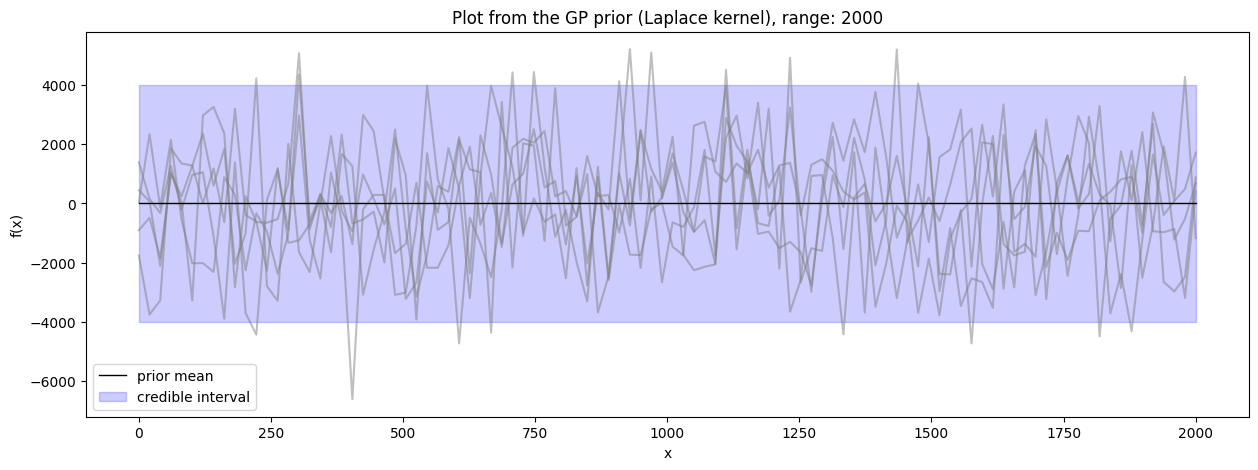

In [63]:
# Lap kernel
# define model
gp = MyFirstGP(kernel = 'Laplace')
gp.init_hypers( theta = [5,25,1])
gp.set_space(np.linspace(0, 1750, 100))

## sample and plot
gp.sample_from_prior(trajectories = 5)
gp.plot_prior(title = 'Plot from the GP prior (Laplace kernel), range: 1750')


gp.set_space(np.linspace(0, 2000, 100))
gp.sample_from_prior(trajectories=5)
gp.plot_prior(title = 'Plot from the GP prior (Laplace kernel), range: 2000')

gp.init_hypers(theta = [2000,1,1])
gp.set_space(np.linspace(0, 1750, 100))

# sample and plot
gp.sample_from_prior(trajectories = 5)
gp.plot_prior(title = 'Plot from the GP prior (Laplace kernel), range: 1750')

gp.set_space(np.linspace(0, 2000, 100))
gp.sample_from_prior(trajectories=5)
gp.plot_prior(title = 'Plot from the GP prior (Laplace kernel), range: 2000')

gp.init_hypers(theta = [1,2000,1])
gp.set_space(np.linspace(0, 1750, 100))

# sample and plot
gp.sample_from_prior(trajectories = 5)
gp.plot_prior(title = 'Plot from the GP prior (Laplace kernel), range: 1750')

gp.set_space(np.linspace(0, 2000, 100))
gp.sample_from_prior(trajectories=5)
gp.plot_prior(title = 'Plot from the GP prior (Laplace kernel), range: 2000')

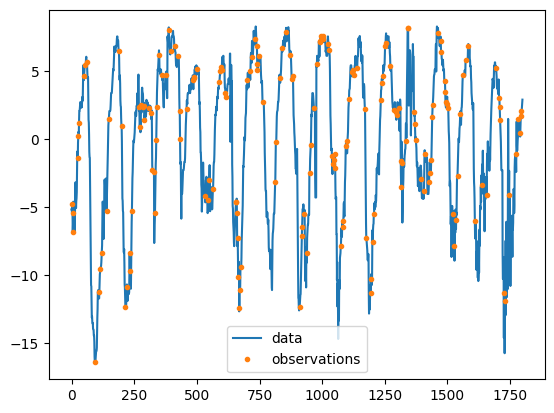

In [24]:
## Data loading

y_data = np.loadtxt('./hr2.txt')
y_data -=np.mean(y_data)
x_data = np.arange(len(y_data))

# randomly keep 10% of the observations -- MODIFY THIS TO EXPLORE THE PERFORMANCE FOR VARYING NUMBERS OF OBSERVATIONS
n = len(y_data)
idx = np.random.choice(n, size=n // 10, replace=False)
idx.sort()

x_obs = x_data[idx]
y_obs = y_data[idx]

# You can add legends and labels to this to make it clearer
plt.plot(x_data,y_data, label = 'data')
plt.plot(x_obs,y_obs,'.', label = 'observations')
plt.legend()

In [25]:
#Task 4 Experiment with different settings
def run_experiments(sizes, inits, methods, kernels=("SE", "Laplace")):

    for kernel in kernels:
        print("\n========== Kernel:", kernel, "==========")

        for init_theta in inits:
            for method in methods:
                for size in sizes:
                    gp = MyFirstGP(kernel=kernel)
                    idx = np.random.choice(n, size=size, replace=False)
                    idx.sort()

                    gp.x_obs = x_data[idx]
                    gp.y_obs = y_data[idx]
                    gp.init_hypers(init_theta)

                    res, final_nll = gp.train(method=method)

                    print(
                        "Init =", init_theta, "with size", size,
                        "| Method =", method,
                        "| Final NLL =", round(final_nll, 3),
                        "| Iter =", getattr(res, "nit", "-")
                    )


In [26]:
size = [90, 180]
init = [[10, 25, 1], [5, 40, 5]]
methods = ["L-BFGS-B", "Nelder-Mead"]
run_experiments(size, init, methods)


========== Kernel: SE ==========
Init = [10, 25, 1] with size 90 | Method = L-BFGS-B | Final NLL = 245.826 | Iter = 12
Init = [10, 25, 1] with size 180 | Method = L-BFGS-B | Final NLL = 454.099 | Iter = 17
Init = [10, 25, 1] with size 90 | Method = Nelder-Mead | Final NLL = 241.922 | Iter = 88
Init = [10, 25, 1] with size 180 | Method = Nelder-Mead | Final NLL = 428.133 | Iter = 112
Init = [5, 40, 5] with size 90 | Method = L-BFGS-B | Final NLL = 240.462 | Iter = 28
Init = [5, 40, 5] with size 180 | Method = L-BFGS-B | Final NLL = 438.548 | Iter = 16
Init = [5, 40, 5] with size 90 | Method = Nelder-Mead | Final NLL = 236.481 | Iter = 130
Init = [5, 40, 5] with size 180 | Method = Nelder-Mead | Final NLL = 439.836 | Iter = 153

========== Kernel: Laplace ==========
Init = [10, 25, 1] with size 90 | Method = L-BFGS-B | Final NLL = 250.488 | Iter = 9
Init = [10, 25, 1] with size 180 | Method = L-BFGS-B | Final NLL = 439.279 | Iter = 16
Init = [10, 25, 1] with size 90 | Method = Nelder-Me

In [27]:
## Train the GP

# SE kernel
gpSE = MyFirstGP(kernel = 'SE')
gpSE.init_hypers(theta = [5,25,1])

# optimise
gpSE.load_data(x_obs,y_obs)
_, lossSE = gpSE.train("L-BFGS-B")

print(f'loss of SE kernel is {lossSE}')

# Lap kernel
gpLap = MyFirstGP(kernel = 'Laplace')
gpLap.init_hypers(theta = [5,25,1])

# optimise
gpLap.load_data(x_obs,y_obs)
_, lossLap = gpLap.train("L-BFGS-B")

print(f'loss of Laplace kernel is {lossLap}')


loss of SE kernel is 419.8873772894
loss of Laplace kernel is 435.90371751114094


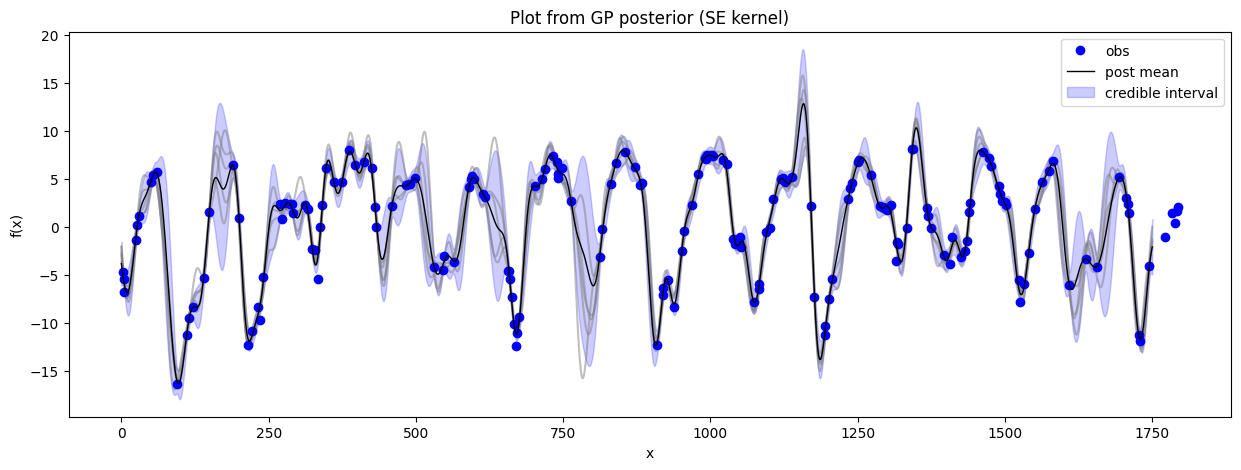

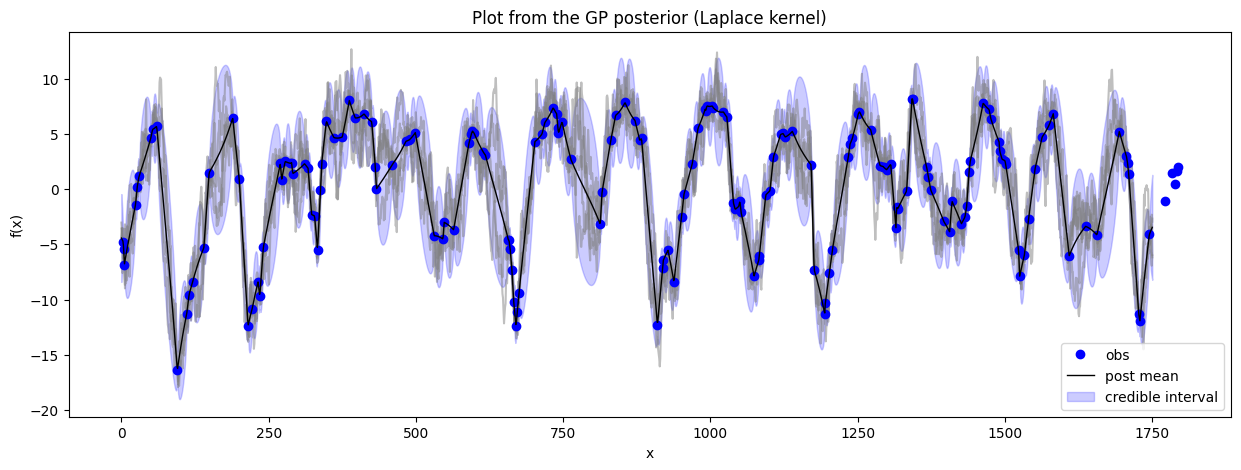

In [28]:
# sample from posterior
gpSE.set_space(np.linspace(0, 1750, 2000))
gpSE.sample_from_posterior(trajectories = 5)
gpSE.plot_posterior(title = 'Plot from GP posterior (SE kernel)')


gpLap.set_space(np.linspace(0, 1750, 2000))
gpLap.sample_from_posterior(trajectories = 5)
gpLap.plot_posterior(title = 'Plot from the GP posterior (Laplace kernel)')


In [29]:
all_idx = np.arange(n)
test_idx = np.setdiff1d(all_idx, idx)

x_test = x_data[test_idx]
y_test = y_data[test_idx]
M = 200
# --- SE kernel GP: predict on test set ---
gpSE.set_space(x_test)
# Activate posterior
gpSE.sample_from_posterior(M)
yhat_se = gpSE.post_mean
mse_se = np.mean((y_test - yhat_se)**2)

# --- Laplace kernel GP: predict on test set ---
gpLap.set_space(x_test)
# Activate posterior
gpLap.sample_from_posterior(M)
yhat_lap = gpLap.post_mean
mse_lap = np.mean((y_test - yhat_lap)**2)

print("Test MSE (SE):", mse_se)
print("Test MSE (Laplace):", mse_lap)

Test MSE (SE): 4.2919340035291915
Test MSE (Laplace): 4.241774472046322
